In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
import math
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_excel("Sample - Superstore.xls",parse_dates=['Order Date'])
df['Month']=df['Order Date'].dt.month
df['Day']=df['Order Date'].dt.day
furniture = df.loc[df['Category'] == 'Furniture']

In [3]:
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Month,Day
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,11,8
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,11,8
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,10,11
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694,6,9
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092,6,9


In [4]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [5]:
furniture['Segment'].unique()

array(['Consumer', 'Corporate', 'Home Office'], dtype=object)

In [6]:
furniture.groupby('Segment')['Segment', 'Sales'].sum()

,Sales
Segment,
Consumer,391049.3120
Corporate,229019.7858
Home Office,121930.6975


In [7]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
#office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

furniture.rename(columns={'Order Date':'order_Date'}, inplace=True)
furniture.head()

,order_Date,Sales,Month,Day
7474,2014-01-06,2573.820,1,6
7660,2014-01-07,76.728,1,7
866,2014-01-10,51.940,1,10
716,2014-01-11,9.940,1,11
2978,2014-01-13,545.940,1,13


In [8]:
furniture = furniture.groupby('order_Date')['Sales','Month','Day'].sum().reset_index()

In [9]:
furniture = furniture.set_index('order_Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='order_Date', length=889, freq=None)

In [10]:
furniture.head()

,Sales,Month,Day
order_Date,,,
2014-01-06,2573.820,1,6
2014-01-07,76.728,1,7
2014-01-10,51.940,1,10
2014-01-11,9.940,1,11
2014-01-13,879.939,2,26


In [11]:

Y = furniture['Sales']
X = furniture.drop(columns=['Sales'], axis=1)

In [12]:
X.head()

,Month,Day
order_Date,,
2014-01-06,1,6
2014-01-07,1,7
2014-01-10,1,10
2014-01-11,1,11
2014-01-13,2,26


In [13]:
X.drop(columns=['Month'], axis=1)

,Day
order_Date,
2014-01-06,6
2014-01-07,7
2014-01-10,10
2014-01-11,11
2014-01-13,26
...,...
2017-12-24,120
2017-12-25,125
2017-12-28,168


In [14]:
furniture.head()

,Sales,Month,Day
order_Date,,,
2014-01-06,2573.820,1,6
2014-01-07,76.728,1,7
2014-01-10,51.940,1,10
2014-01-11,9.940,1,11
2014-01-13,879.939,2,26


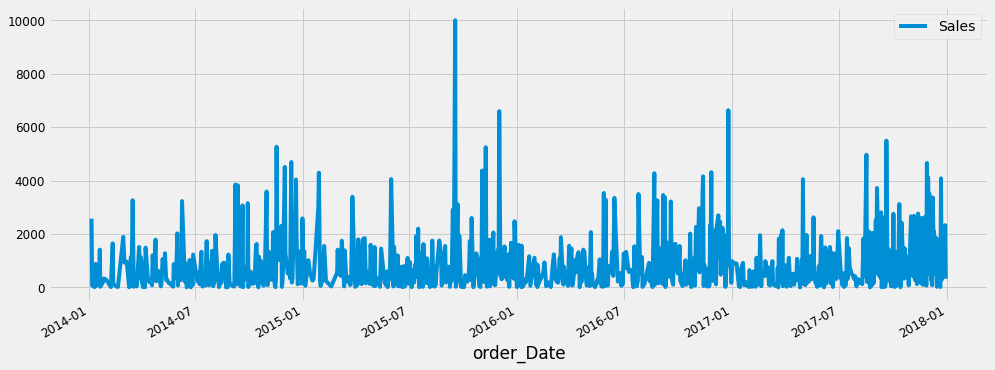

In [15]:
furniture1 = furniture.drop(columns = ['Day', 'Month'],axis=1)
furniture1.plot(figsize=(15, 6))
plt.show()

## Let’s first plot AutoCorelation Function(ACF) and PartialAutoCorelation Function (PACF) using statsmodel library:

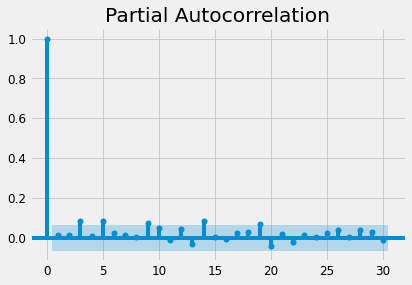

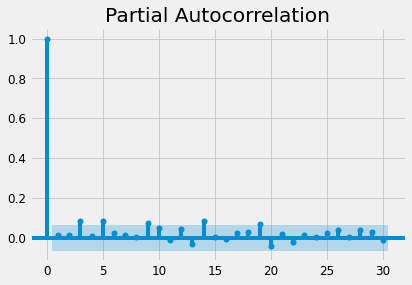

In [16]:
tsa_plots.plot_pacf(Y)

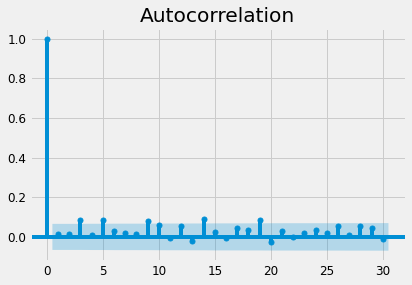

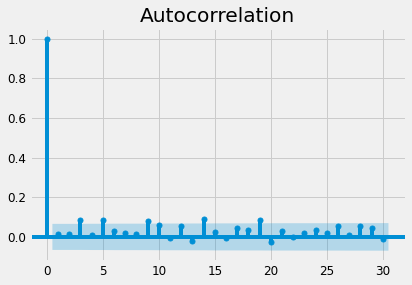

In [17]:
tsa_plots.plot_acf(Y)

## Decomposing components


In [19]:
#from pylab import rcParams
#rcParams['figure.figsize'] = 18, 8
#decomposition = sm.tsa.seasonal_decompose(Y, model='additive')
#fig = decomposition.plot()
#plt.show()

## Stationarity check — ADF test

In [20]:
result = adfuller(Y, autolag = 'AIC')
result

(-11.408352041528074,
 7.354250253762409e-21,
 4,
 884,
 {'1%': -3.4377689935918783,
  '5%': -2.864815046188292,
  '10%': -2.5685138660653957},
 14472.061275954824)

In [21]:
if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")

Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [22]:
#TimeSeriesSplit incrementally splits the data in a cross-validation manner. We have to use the last X_train, X_test set.
tss = TimeSeriesSplit()
for train_index, test_index in tss.split(X,Y):
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index] 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

In [23]:
auto_model = auto_arima(Y_train.to_numpy(), exogenous=X_train.to_numpy(), m=12, seasonal=True,
                        suppress_warnings = True,  
                        step_wise=True, trace=True)           
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12013.620, Time=0.18 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12019.781, Time=0.51 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=12019.971, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=12024.500, Time=0.22 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=12017.621, Time=0.37 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=12017.782, Time=0.43 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=12017.590, Time=1.37 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=12015.994, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=12015.598, Time=0.49 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=12017.496, Time=0.58 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 7.810 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  741
Model:                        SARIMAX   Log Likelihood               -6002.810
Date:                Sun, 24 Apr 2022   AIC                          12013.620
Time:                        18:38:12   BIC                          12032.052
Sample:                             0   HQIC                         12020.726
                                - 741                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    160.1648     51.826      3.090      0.002      58.587     261.742
x1            27.3602      1.468     18.634      0.000      24.482      30.238
x2             5.3062      0.747      7.106      0.000       3.843       6.770
sigma2      6.324e+05   1.58e+04     40.007      0.000    6.01e+05    6.63e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8010.76
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             2.72
Prob(H) (two-sided):                  0.13   Kurtosis:                        18.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
model = SARIMAX(endog=Y_train.to_numpy(), exog=X_train.to_numpy().astype(float), 
                order=(1, 0, 0),seasonal_order=(0, 0, 0, 12))
model = model.fit(disp=False)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  741
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -6009.049
Date:                Sun, 24 Apr 2022   AIC                          12026.098
Time:                        18:38:16   BIC                          12044.530
Sample:                             0   HQIC                         12033.204
                                - 741                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            29.3884      1.420     20.693      0.000      26.605      32.172
x2             6.9743      0.729      9.562      0.000       5.545       8.404
ar.L1          0.0248      0.036      0.697      0.486      -0.045       0.095
sigma2      6.399e+05   1.52e+04     42.009      0.000     6.1e+05     6.7e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              6386.71
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             2.44
Prob(H) (two-sided):                  0.08   Kurtosis:                        16.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:

result = model.predict(start=1, end=148, exog=X_test.to_numpy().astype(float))

In [26]:
len(X_test), len(Y_test), len(result), len(X_train)


(148, 148, 148, 741)

In [27]:
from sklearn.metrics import mean_squared_error
mean_squared_error(result,Y_test)

1551671.5436809086

In [28]:
print('Root Mean Squared Error (RMSE): ', math.sqrt(mean_squared_error(result, Y_test)))

Root Mean Squared Error (RMSE):  1245.6610870059756


<AxesSubplot:>

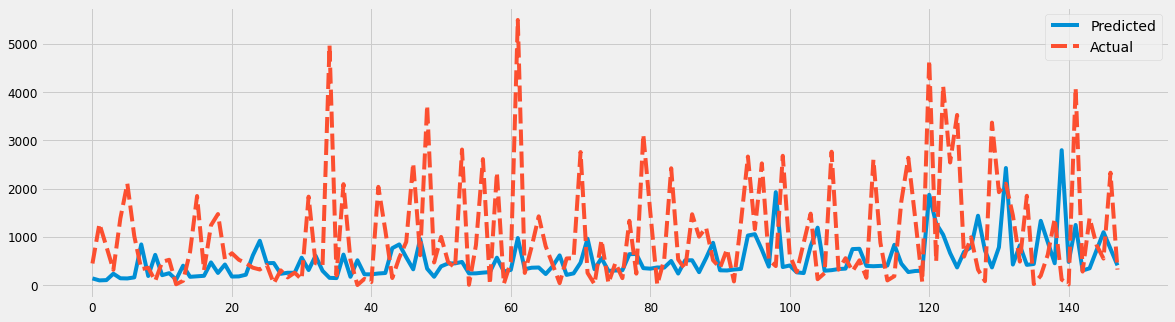

In [29]:
plt.figure(figsize=(18,5))
sns.lineplot(data=pd.DataFrame({'Predicted':result,'Actual':Y_test.to_numpy()}))

   ## With Additional Variable
   

In [30]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 23), (6026, 23))

In [31]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales','Order Date':'order_Date'}, inplace=True)
store.head()


,order_Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


In [32]:
store.isnull().sum()

order_Date         0
furniture_sales    0
office_sales       0
dtype: int64

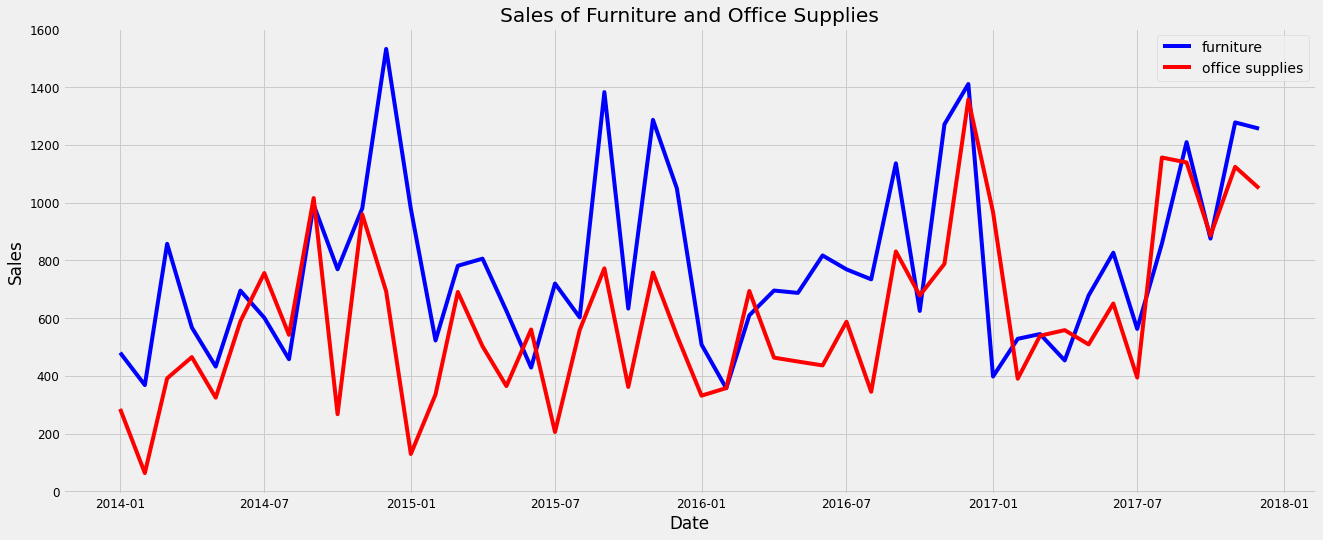

In [33]:
plt.figure(figsize=(20, 8))
plt.plot(store['order_Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['order_Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

In [34]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'order_Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))


Office supplies first time produced higher sales than furniture is 2014-07-01.


In [35]:
store.head(5)

,order_Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


In [36]:
store=store.set_index(['order_Date'])

In [37]:

Y_div = store['furniture_sales']
X_div = store.drop(columns=['furniture_sales'], axis=1)

In [38]:
result1 = adfuller(store['office_sales'], autolag = 'AIC')
result1

(-4.664633175077928,
 9.801371572373162e-05,
 0,
 47,
 {'1%': -3.5778480370438146,
  '5%': -2.925338105429433,
  '10%': -2.6007735310095064},
 520.2817884281114)

In [39]:
if result1[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")

Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [40]:
tss_div = TimeSeriesSplit()
for train_index_div, test_index_div in tss_div.split(X_div,Y_div):
    Y_train_div, Y_test_div = Y_div.iloc[train_index_div], Y_div.iloc[test_index_div] 
    X_train_div, X_test_div = X_div.iloc[train_index_div], X_div.iloc[test_index_div]

In [41]:
auto_model_div = auto_arima(Y_train_div.to_numpy(), exogenous=X_train_div.to_numpy(), m=12, seasonal=True,
                        suppress_warnings = True,  
                        step_wise=True, trace=True)           
auto_model_div.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=563.784, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=562.875, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=577.060, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=564.733, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=560.407, Time=0.46 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=560.491, Time=0.41 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(2,0,0)[12]             : AIC=inf, Time=0.26 sec

Best

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   40
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -274.203
Date:                            Sun, 24 Apr 2022   AIC                            560.407
Time:                                    18:38:42   BIC                            570.540
Sample:                                         0   HQIC                           564.070
                                             - 40                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    259.2449    171.708      1.510      0.131     -77.297     595.787
x1             1.0229      0.155      6.619      0.000       0.720       1.326
ar.L1          0.1119      0.161      0.693      0.488      -0.205       0.428
ar.S.L12       0.0306      0.220      0.139      0.889      -0.400       0.462
ar.S.L24      -0.7849      0.086     -9.106      0.000      -0.954      -0.616
sigma2      2.951e+04   9500.681      3.106      0.002    1.09e+04    4.81e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.82   Prob(JB):                         0.51
Heteroskedasticity (H):               0.82   Skew:                             0.42
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
model_div = SARIMAX(endog=Y_train_div.to_numpy(), exog=X_train_div.to_numpy().astype(float), 
                order=(0, 0, 0),seasonal_order=(1, 0, 0, 12))
model_div = model_div.fit(disp=False)
model_div.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   40
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood                -286.493
Date:                  Sun, 24 Apr 2022   AIC                            578.987
Time:                          18:38:44   BIC                            584.053
Sample:                               0   HQIC                           580.819
                                   - 40                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2212      0.082     14.848      0.000       1.060       1.382
ar.S.L12       0.0630      0.251      0.251      0.802      -0.429       0.555
sigma2      9.783e+04   1.99e+04      4.922      0.000    5.89e+04    1.37e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):                 0.61
Prob(Q):                              0.37   Prob(JB):                         0.74
Heteroskedasticity (H):               0.62   Skew:                            -0.06
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
result_div = model_div.predict(start=1, end=8, exog=X_test_div.to_numpy().astype(float))

In [44]:
len(X_test_div), len(Y_test_div), len(result_div), len(X_train_div)

(8, 8, 8, 40)

In [45]:
mean_squared_error(result_div, Y_test_div)

164906.2561075056

In [47]:
print('Root Mean Squared Error (RMSE): ', math.sqrt(mean_squared_error(result_div, Y_test_div)))

Root Mean Squared Error (RMSE):  406.0865130825026


<AxesSubplot:>

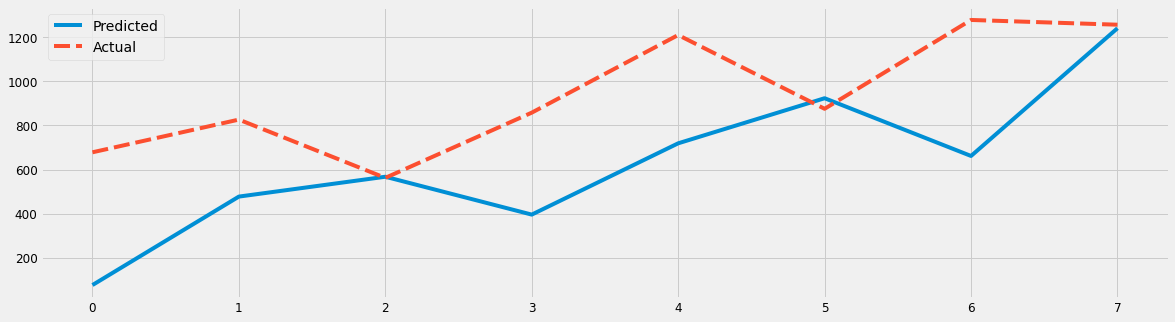

In [48]:
plt.figure(figsize=(18,5))
sns.lineplot(data=pd.DataFrame({'Predicted':result_div,'Actual':Y_test_div.to_numpy()}))

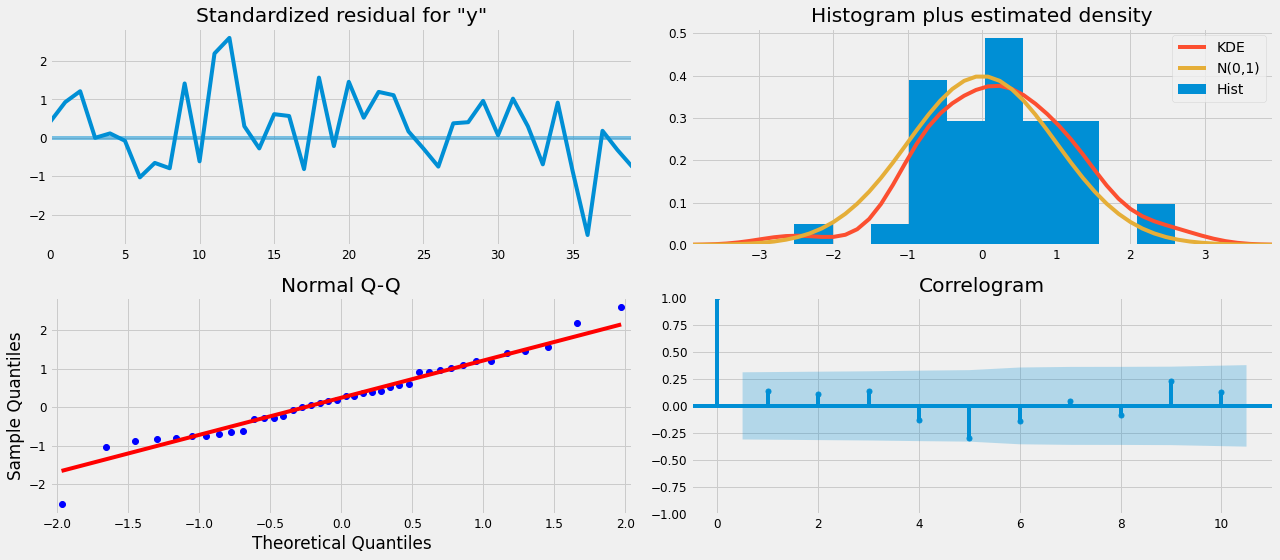

In [49]:
 #error distribution.

model_div.plot_diagnostics()
plt.tight_layout()
plt.show()

## Holt-Winters Model

In [50]:
y = furniture['Sales']

In [51]:
train_data = y[:int(0.7*(len(y)))]
test_data = y[int(0.7*(len(y))):]

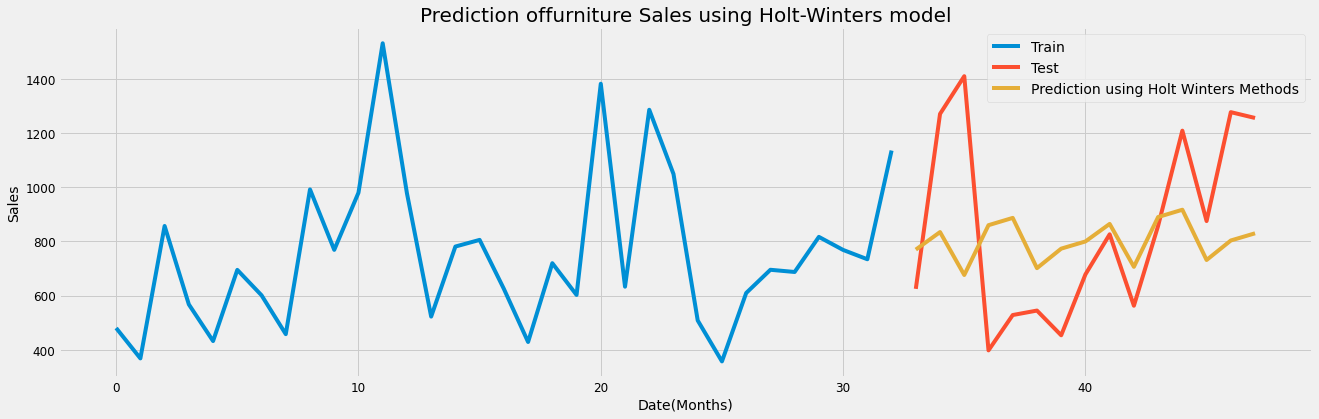

In [52]:
# Fitting the Holt-Winters method for Sales.
from statsmodels.tsa.api import ExponentialSmoothing
model_holt_winters = ExponentialSmoothing(train_data, seasonal_periods=7, trend='additive', seasonal='additive').fit() 
pred = model_holt_winters.forecast(len(test_data))# Predict the test data
#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction offurniture Sales using Holt-Winters model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred, label='Prediction using Holt Winters Methods')
plt.legend(loc='best')
plt.xlabel('Date(Months)', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.show()

In [53]:


print('Mean Squared Error (MSE) of Holt-Winters: ', mean_squared_error(test_data, pred))
print('Root Mean Squared Error (RMSE) of Holt-Winters: ', math.sqrt(mean_squared_error(test_data, pred)))
print('Mean Absolute Deviation (MAD) of Holt-Winters: ', mean_absolute_error(test_data, pred))

Mean Squared Error (MSE) of Holt-Winters:  118113.00674174663
Root Mean Squared Error (RMSE) of Holt-Winters:  343.6757290553795
Mean Absolute Deviation (MAD) of Holt-Winters:  285.826994663574


In [54]:
df = pd.read_excel("Sample - Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

furniture['Order Date'].min(), furniture['Order Date'].max()

cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [55]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

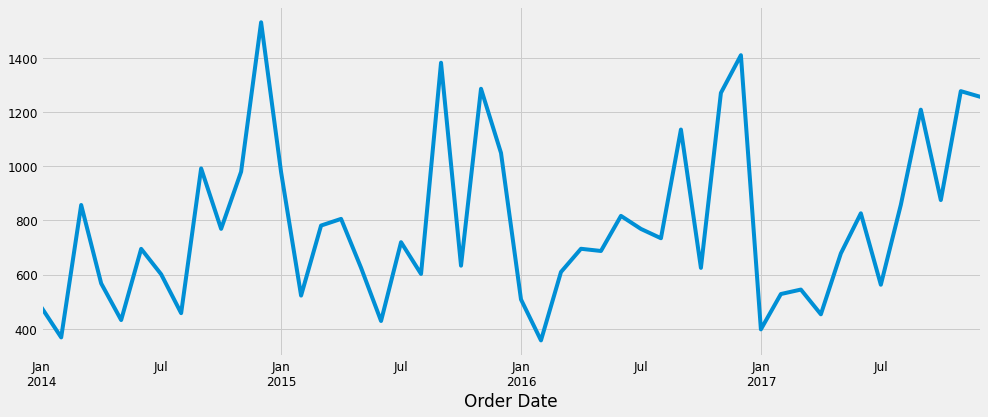

In [56]:
y = furniture['Sales'].resample('MS').mean()

y.plot(figsize=(15, 6))
plt.show()

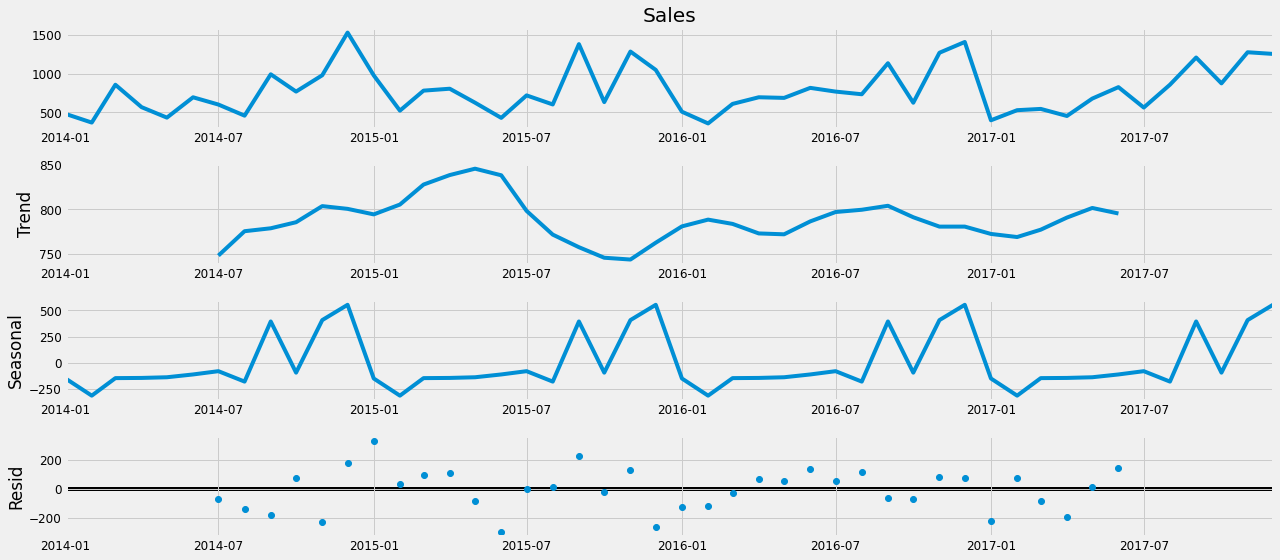

In [57]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [59]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [60]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1436.7096275959661
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793748
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1131.1862176526117
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280301923
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758111
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2677.925835775167
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091534
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673292
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5890624047003
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2513.2838482013117
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468657
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576517064
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1508.9266604104025
ARIM

In [61]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


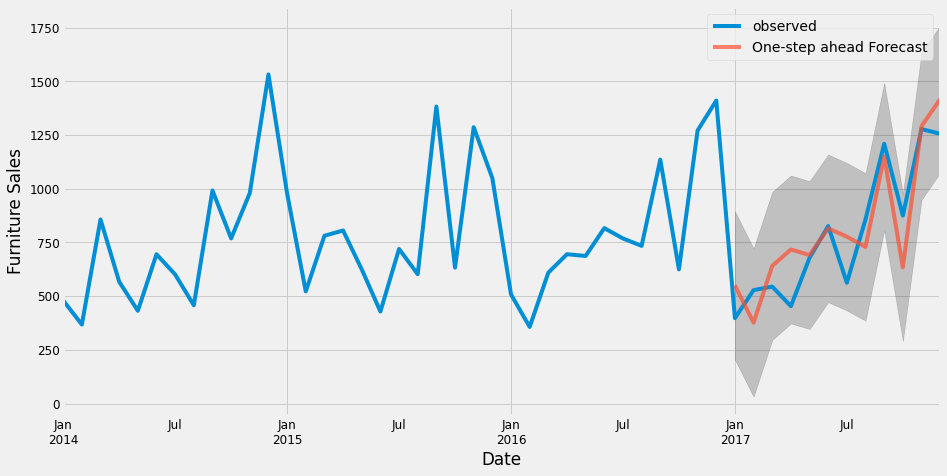

In [62]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()


In [63]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 22993.56


In [64]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


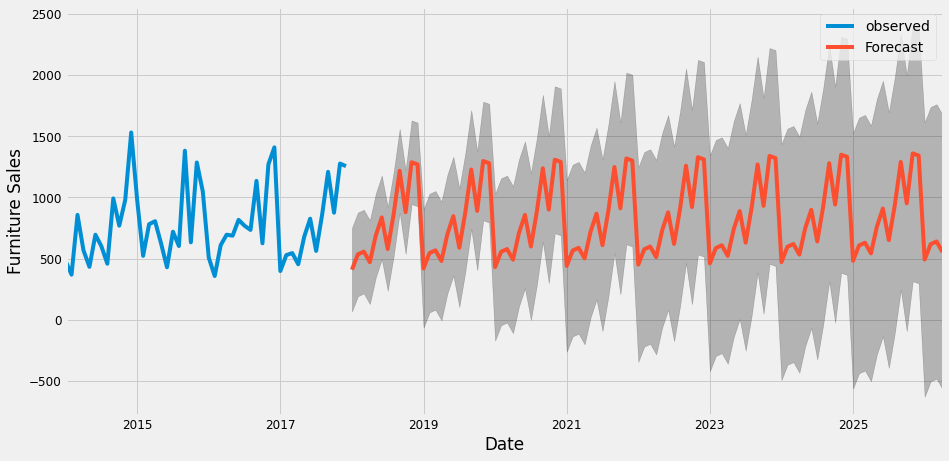

In [65]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()


In [66]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [67]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()


,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


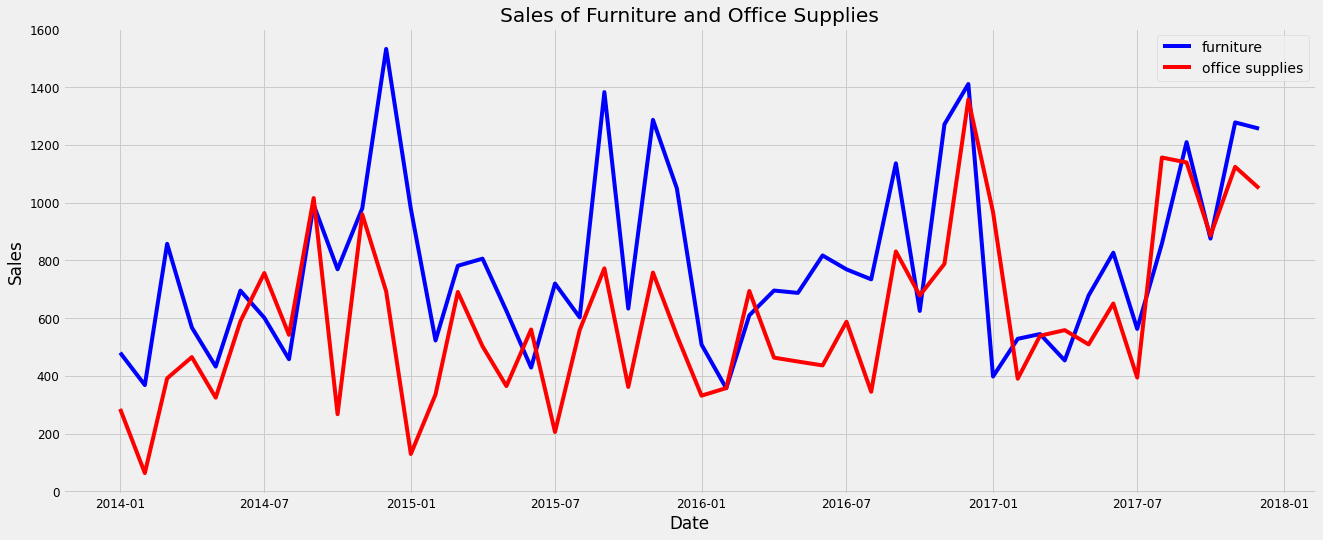

In [68]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

In [69]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))


Office supplies first time produced higher sales than furniture is 2014-07-01.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

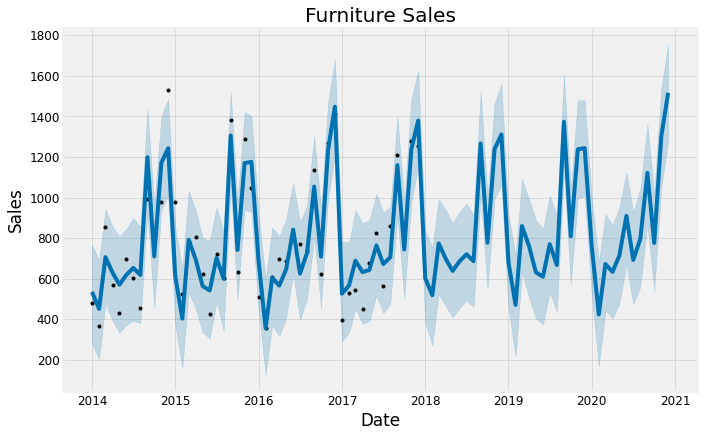

In [70]:
from fbprophet import Prophet
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

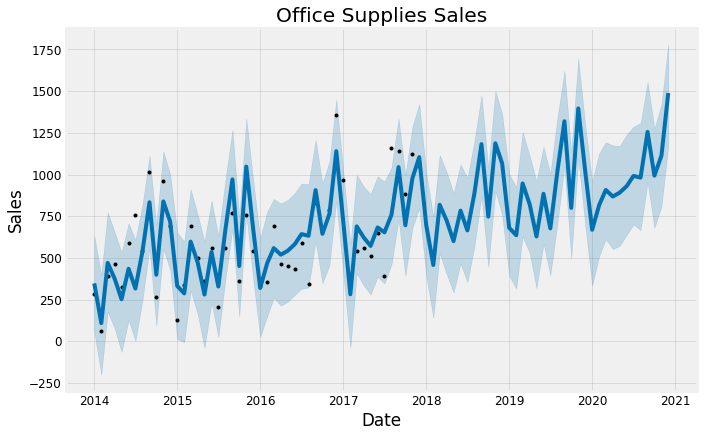

In [71]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

In [72]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()


,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,279.832464,764.743533,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,203.608767,690.910447,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,478.877181,943.061733,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,393.091346,855.480967,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,333.373717,808.756950,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


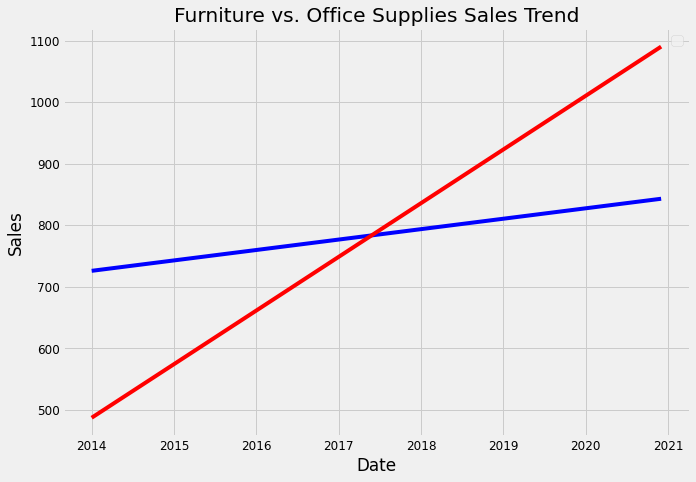

In [73]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

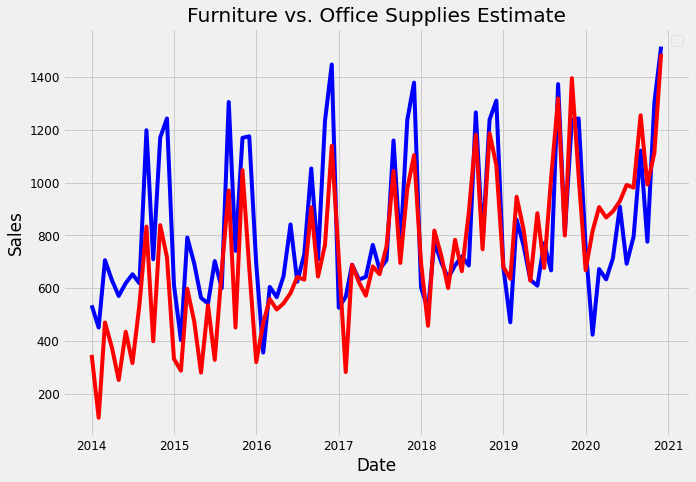

In [74]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');


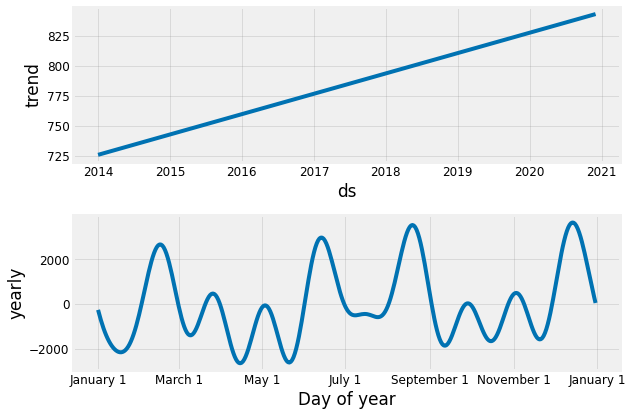

In [75]:
furniture_model.plot_components(furniture_forecast);

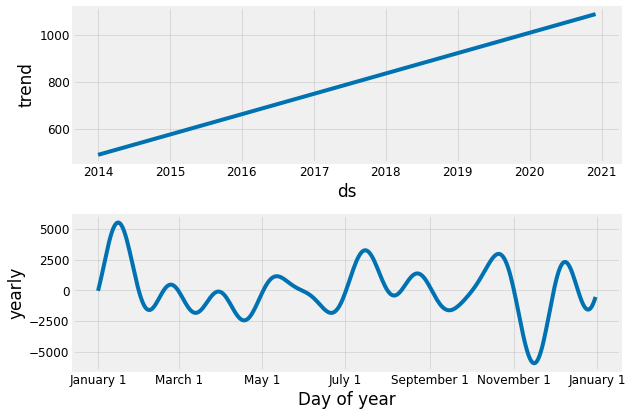

In [76]:
office_model.plot_components(office_forecast);